In [25]:
using MAT, Statistics, LinearAlgebra,Random, Plots, NonlinearSolve
using StaticArrays, ForwardDiff, Distributed, StaticArrays, SciMLNLSolve, SimpleNonlinearSolve
include("mvnrnd.jl")

mvnrnd (generic function with 1 method)

In [11]:
function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    if size(v,2) == 1 # check if v is a column vector
        @eval (($s) = (vec($v)))
    else
        @eval (($s) = ($v))
    end
end

file = matopen("simulationData.mat")

#Reads in ju[IO, price, Omega, data, labor, mu, aggtfp, alpha, grossy, stfp, beta, agggdp, Sigma, capital, vadd]

varnames = names(file)
for varname in varnames
    val = read(file, varname)
    # Instantiate the variable with its name in the current scope
    string_as_varname(varname,val)
    end

close(file)



In [3]:
function getVariables(year)
    IO = data[data[:,1] .== year,:]
    temp = [8,60,62,80:88...]
    IO = IO[setdiff(1:end,temp),setdiff(1:end,[1,2,3,4,5,94])]
    IO = IO[:,setdiff(1:end,temp)]
    Ω = IO ./ sum(IO,dims=2)
    α = vadd[:,year-1959] ./ grossy[:,year-1959];
    β = (grossy[:,year-1959]' * (I-diagm(1 .- α)*Ω))';
    β[beta .< 0] .= 0
    β = β / sum(β)
    λ = (inv(I - diagm(1 .- alpha)*Ω)' * β);
    L = λ .* α
    
    return α,β,Ω,L,λ

end

getVariables (generic function with 1 method)

In [4]:
domar_weights = (inv(I - diagm(1 .- alpha) * Omega)' * beta);
L = domar_weights .* alpha;

In [5]:
ε = .5;
θ = 0.001;
σ = .9;

In [46]:
function problem(X :: AbstractVector{T}, A, β, Ω, α, ε, θ, σ,L) where T



    N = length(α)
    p = X[1:N]
    y = X[N+1:end]
    
    Out :: Vector{T} = zeros(eltype(X),2*N)
    
    q = (Ω * p .^ (1-θ)) .^ (1 / (1 - θ))
    w = p .* (A .^ ((ε - 1)/ε)) .* (α .^ (1 / ε)) .* (y .^ (1/ε)) .* L .^ (-1/ε)
    C = w' * L
  
    Out[1:N] = p - (A .^ (ε - 1) .* (α .* w .^ (1- ε) + (1 .- α) .* q .^ (1 - ε))) .^ (1/(1-ε))
    Out[N+1:end] = y' - y' * diagm(p)^ε * diagm(A)^(ε-1) * diagm(q)^(θ-ε) * diagm(1 .- α) * Ω * diagm(p)^(-θ) - β'*diagm(p)^(-σ)*C
    
    return Out
end

problem (generic function with 1 method)

In [47]:
function problemJacobian(X, A, β, Ω, α, ε, θ, σ,L)
    N = length(α)
    p = @view X[1:N]
    y = @view X[N+1:end]
    
    Out = zeros(eltype(X),2*N)
    
    q = (Ω * p .^ (1-θ)) .^ (1 / (1 - θ))
    w = p .* (A .^ ((ε - 1)/ε)) .* (α .^ (1 / ε)) .* (y .^ (1/ε)) .* L .^ (-1/ε)
    C = w' * L
  
    
    DQDP = (q .^ θ * (p.^(-θ))') .* Ω;
    DWDP = diagm(A.^((ε-1)/ε) .* α.^(1/ε) .* y.^(1/ε) .* (1 ./ L).^(1/ε));
    DWDY = (1/ε) * diagm(p .* A.^((ε-1)/ε) .* α.^(1/ε).* (y.^(1/ε-1)) .* L.^(-1/ε));
    DCDP = DWDP' * L; 
    DCDY = DWDY' * L;

    DOut1DP = I - diagm(diagm(A)^(-1) * ((α .* (w .^ (1-ε)) + (1 .- α) .* (q.^(1-ε)))).^(ε/(1-ε))) * (diagm(α) * diagm(w.^(-ε))* DWDP + diagm(1 .-α)*diagm(q.^(-ε))*DQDP);

    DOut1DY =  -diagm(diagm(A.^(-1))*((α.*(w.^(1-ε))+(1 .- α).*(q.^(1-ε)))).^(ε/(1-ε)))*(diagm(α)*diagm(w.^(-ε))*DWDY);

    DOut2DP = -(ε * diagm(p.^(-θ))*Ω'*diagm((p.^(ε-1)).*(y).*(q.^(θ-ε)).*(1 .- α).*(A.^(ε-1)))
        + (θ-ε)*diagm(p.^(-θ))*Ω'*diagm((p.^(ε)).*(y).*(q.^(θ-ε-1)).*(1 .- α).*(A.^(ε-1)))*DQDP 
        - σ*diagm(β.*p.^(-σ-1))*C + broadcast(*, β.*(p.^(-σ)), DCDP')
        - θ* diagm(p.^(-θ-1)).*diagm(Ω'*diagm((p.^(ε)).*(q.^(θ-ε)).*(1 .- α).*(A.^(ε-1)))*y));

    DOut2DY = I - (diagm(p)^ε*diagm(A)^(ε-1)*diagm(q)^(θ-ε)*diagm(1 .- α)*Ω*diagm(p)^(-θ))' - broadcast(*, β.*(p.^(-σ)), DCDY');
    OutDeriv = [DOut1DP DOut1DY; DOut2DP DOut2DY];

end

problemJacobian (generic function with 1 method)

In [48]:
trials = 500;
GDP = zeros(trials)
λ = zeros(76,trials)


f = NonlinearFunction((u,p) -> problem(u,p,beta,Omega,alpha,ε,θ,σ,L), jac = (u,p) -> problemJacobian(u,p,beta,Omega,alpha,ε,θ,σ,L))

for k in 1:trials
    
        
    A = exp.(mvnrnd(-1/2*diag(Sigma),diagm(diag(Sigma))));
    init = SA[Complex.(exp.(-inv(I - diagm(1 .- alpha)*Omega)*log.(A)))..., Complex.(domar_weights ./exp.(-inv(I - diagm(1 .- alpha) * Omega)*log.(A)))...];
    
    
    p = A
    ProbN = NonlinearProblem(f,init,p)

    x = real.(solve(ProbN,NewtonRaphson(), reltol = 1e-8,abstol = 1e-8).u)
    
    GDP[k] = (x[1:76] .* (A .^ ((ε-1)/ε)).*(alpha.^(1/ε)).*(x[77:152].^(1/ε)).* L .^ (-1/ε))' * L;
    λ[:,k] = (x[1:76] .* x[77:end]) / GDP[k] 
        
end

InterruptException: InterruptException:

In [50]:
print(GDP)

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

In [80]:
year = 1999
M = 2000

a = 0.7;
b = 1.3;



(α,β,Ω,L,λ) = getVariables(1982);
f = NonlinearFunction((u,p) -> problem(u,p,β,Ω,α,ε,θ,σ,L), jac = (u,p) -> problemJacobian(u,p,β,Ω,α,ε,θ,σ,L))



GDP = zeros(2*M,3)
sectors = [7 8 53]
sectorShocks = [LinRange(1,a,M)..., LinRange(1,b,M)...]

for i in 1:3
    
    x0 = Complex.([ones(76,1)...,λ...]);
    
    for k in 1:M
        A  = ones(76)
        A[sectors[i]] = sectorShocks[k]
        
        
    
    
        p = A
        ProbN = NonlinearProblem(f,x0,p)
        
        sol = (solve(ProbN,NewtonRaphson(), reltol = 1e-8,abstol = 1e-8))
        
        x = sol.u
        
        p = real.(x[1:76]) 
        y = real.(x[77:152])
        GDP[k,i] = (p .* (A .^ ((ε-1)/ε)).*(alpha.^(1/ε)).*(y.^(1/ε)).* L .^ (-1/ε))' * L
        g = GDP[k,i]
        println("$k: $g")

        x0 =  x
    end
    
    x0 = Complex.([ones(76,1)...,λ...]);

    
    for k in 1:M
        A  = ones(76)
        A[sectors[i]] = sectorShocks[k + M]
        
        
    
    
        p = A
        ProbN = NonlinearProblem(f,x0,p)
        
        x = (solve(ProbN,NewtonRaphson(), reltol = 1e-6,abstol = 1e-6).u)

        

        p = real.(x[1:76]) 
        y = real.(x[77:152])
        
        GDP[k + M,i] = (p .* (A .^ ((ε-1)/ε)).*(alpha.^(1/ε)).*(y.^(1/ε)).* L .^ (-1/ε))' * L
        print(GDP[k + M,i])
        x0 =  x
    end

    GDP[1:M,i] = GDP[M:-1:1,i]
end


In [69]:
GDP[1:M,3] = GDP[M:-1:1,3]

200-element Vector{Float64}:
 0.9674780903838195
 0.9676778621339576
 0.9678771568234957
 0.968075976690039
 0.9682743239555933
 0.9684722008267023
 0.9686696094945982
 0.9688665521353391
 0.9690630309099498
 0.9692590479645548
 ⋮
 0.9989116648774394
 0.9990484945489636
 0.9991850976734358
 0.9993214749887059
 0.9994576272290584
 0.9995935551252106
 0.999729259404346
 0.9998647407901464
 1.0000000000000007

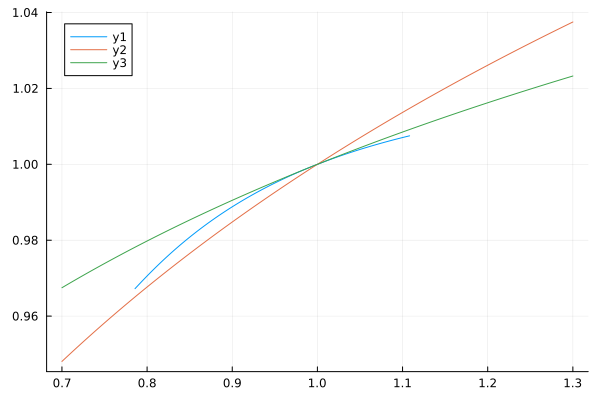

In [81]:
plot(LinRange(a,b,2*M),GDP[:,1])
plot!(LinRange(a,b,2*M),GDP[:,2])
plot!(LinRange(a,b,2*M),GDP[:,3])